In [1]:
import torch
import torch.nn as nn
import torch.utils.data as data
import torchvision.utils as utils
import torchvision.datasets as dataset
import torchvision.transforms as transforms

import h5py
import numpy as np
import matplotlib.pyplot as plt

In [2]:
class Dataset(torch.utils.data.Dataset):
    
    '''Characterizes a dataset for PyTorch'''
    
    def __init__(self, path):
        '''Initialization'''
        # open dataset
        self.dset = h5py.File(path, 'r')
        self.ortho = self.dset['x_ortho']
        self.dsm = self.dset['x_dsm']
        self.dtm = self.dset['x_dtm']
        self.slope = self.dset['x_slope']
        self.ground_truth = self.dset['y_ground_truth']
        
        # set number of samples
        self.length = self.ground_truth.shape[0]
        #self.labels = labels
        #self.list_IDs = list_IDs
        
        ## TODO:
        # make means and stds load from hdf5
        self.means = np.array([106.623276, 14.312894, 1325.6674, 29.272326])
        self.stds = np.array([54.006954, 12.487458, 16.26564, 7.691262])

    def __len__(self):
        '''Denotes the total number of samples'''
        return self.length

    def __getitem__(self, index):
        '''Generates one sample of data'''
        
        # Load data and get label
        
        x0 = (np.array(self.ortho[index]) - self.means[0]) / self.stds[0]
        x1 = (np.array(self.dsm[index]) - self.means[1]) / self.stds[1]
        x2 = (np.array(self.dtm[index]) - self.means[2]) / self.stds[2]
        x3 = (np.array(self.slope[index]) - self.means[3]) / self.stds[3]
        # con
        X = np.concatenate([x0, x1, x2, x3], axis=2)
        # get ground truth       
        y = np.array(self.ground_truth[index])

        return X, y
    
    def show_item(self, index):
        '''shows the data'''
        plt.imshow(np.array(self.ortho[index][:,:,:3]))
    
        
    def show_item_2(self, index):
        '''shows the data'''
        fig, axs = plt.subplots(1, 3)
        
        images = []    
        images.append(axs[0].imshow(np.array(self.ortho[index][:,:,:3])))
        #plt.axis('off')
        images.append(axs[1].imshow(np.array(self.slope[index][:,:,0])))
        #plt.axis('off')
        images.append(axs[2].imshow(np.array(self.ground_truth[index][:,:,0])))
        #plt.axis('off')
        #plt.imshow(np.array(self.slope[index][:,:,0]))
        #plt.colorbar()
        plt.show()
        
        
    def show_item_3(self, index):
        '''shows the data'''
        #plt.imshow(np.array(self.ground_truth[index]))
        
        fig = plt.figure(figsize=(20,20))
        
        a = fig.add_subplot(2, 3, 1)
        imgplot = plt.imshow(np.array(self.ortho[index][:,:,:3]))
        a.set_title('RGB')
        plt.colorbar(ticks=[0.1, 0.3, 0.5, 0.7], orientation='horizontal')
        plt.axis('off')
        
        a = fig.add_subplot(2, 3, 2)
        imgplot = plt.imshow(np.array(np.roll(self.ortho[index], 1, axis=2)[:,:,:3]))
        a.set_title('CIR')
        plt.colorbar(ticks=[0.1, 0.3, 0.5, 0.7], orientation='horizontal')
        plt.axis('off')
        
        a = fig.add_subplot(2, 3, 3)
        imgplot = plt.imshow(np.array(self.dsm[index]))
        imgplot.set_clim(0.0, 40.0)
        a.set_title('Tree Height')
        plt.colorbar(ticks=[10, 20, 30], orientation='horizontal')
        plt.axis('off')
        
        a = fig.add_subplot(2, 3, 4)
        imgplot = plt.imshow(np.array(self.slope[index]), cmap="nipy_spectral")
        imgplot.set_clim(0.0, 90.0)
        a.set_title('Slope')
        plt.colorbar(ticks=[15, 30, 45, 60, 75], orientation='horizontal')
        plt.axis('off')
        
        a = fig.add_subplot(2, 3, 5)
        imgplot = plt.imshow(np.array(self.ground_truth[index]), cmap="hot")
        imgplot.set_clim(0, 7)
        a.set_title('Ground Truth')
        plt.colorbar(ticks=[1, 2, 3, 4, 5, 6], orientation='horizontal')
        plt.axis('off')
        
        
    def close(self):
        ''' closes the hdf5 file'''
        self.dset.close()

In [3]:
90/6

15.0

In [4]:
dset = Dataset("/home/philipp/Data/edin_dataset/dataset_512_1.h5")

KeyError: "Unable to open object (object 'x_dsm' doesn't exist)"

In [5]:
X, y = dset[14]

In [6]:
X.shape

(512, 512, 7)

In [7]:
y.shape

(512, 512, 1)

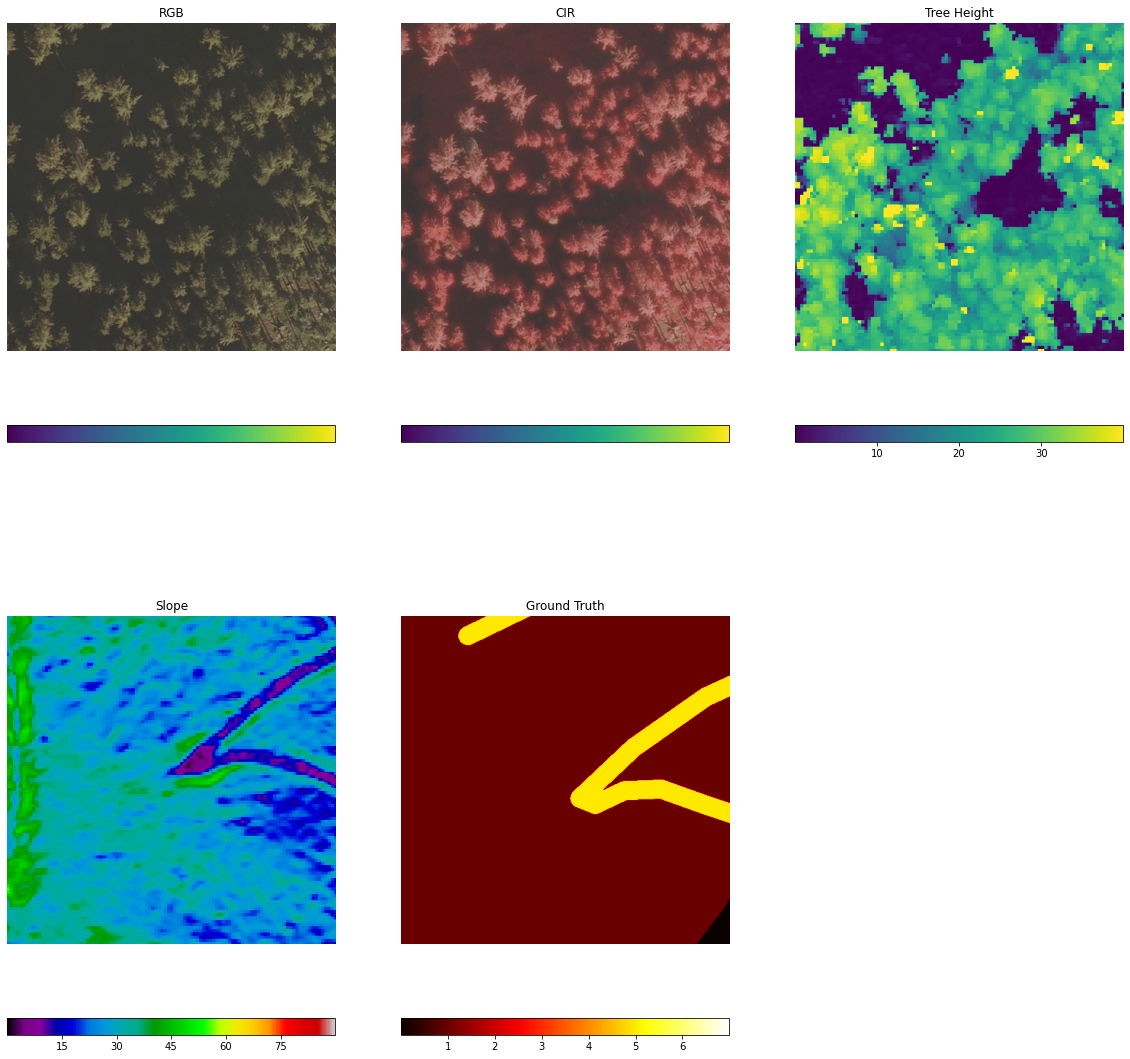

In [11]:
dset.show_item_3(41)

In [29]:
len(dset)

100

In [13]:
1500/250

6.0

In [238]:
trainloader = torch.utils.data.DataLoader(dset, batch_size=64, shuffle=True, 
                                          num_workers=1, pin_memory=True)

In [239]:
trainloader

In [ ]:
class RandomCrop(object):
    """Crop randomly the image in a sample.

    Args:
        output_size (tuple or int): Desired output size. If int, square crop
            is made.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        if isinstance(output_size, int):
            self.output_size = (output_size, output_size)
        else:
            assert len(output_size) == 2
            self.output_size = output_size

    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']

        h, w = image.shape[:2]
        new_h, new_w = self.output_size

        top = np.random.randint(0, h - new_h)
        left = np.random.randint(0, w - new_w)

        image = image[top: top + new_h,
                      left: left + new_w]

        landmarks = landmarks - [left, top]

        return {'image': image, 'landmarks': landmarks}

In [ ]:
class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']

        # swap color axis because
        # numpy image: H x W x C
        # torch image: C X H X W
        image = image.transpose((2, 0, 1))
        image = image.transpose((2, 0, 1))
        return {'image': torch.from_numpy(image),
                'landmarks': torch.from_numpy(landmarks)}
